This Jupyter Notebook is meant to be accessed via Google Colab and will be the main method to train models on Google Colab.

###Check for GPU; mount GDrive; Install requirements; import packages and functions

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Sun Nov 29 19:05:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Drum-Tabber
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Drum-Tabber
Drum-Tabber-Google-Colab-Notebook.ipynb  __pycache__	   src
Jupyter-Notebooks			 README.md	   train.py
logs					 requirements.txt
models					 sample_dataset


In [3]:
!pip install -r ./requirements.txt

     |████████████████████████████████| 184kB 21.9MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=6ce45e05a13f124b20c15ef2722af1aa5049acdb0a90e9b322bb15aafee7f5db
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [4]:
# primary importing code block to utilize the python files
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, BatchNormalization, MaxPool2D
from pydub import AudioSegment   # main class from pydub package used to upload mp3 into Python and then get a NumPy array
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed
import librosa as lb             # loads the librosa package
import librosa.display
from src.configs import *
from src.utils import MusicAlignedTab, create_FullSet_df, one_hot_encode, collapse_class, clean_labels
from src.utils import save_drum_tabber_model, load_drum_tabber_model, create_configs_dict
from src.dataset import Dataset
import src.utils as ut

### Partial Code Testing

In [ ]:
mat = MusicAlignedTab('wolves_at_the_door')
df = mat.MAT

In [ ]:
df = clean_labels(df)
MusicAlignedTab.labels_summary(df)
df = collapse_class(df, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(df)

In [8]:
encode_df = one_hot_encode(df)
print(encode_df.columns)
encode_df.head()

one_hot_encode: col_list before encoding = ['tk', 'BD', 'SD', 'HH', 'at', 'ac']
one_hot_encode: col_list after encoding = ['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o', 'HH_x', 'at_o', 'ac_x']
Index(['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o',
       'HH_x', 'at_o', 'ac_x'],
      dtype='object')


,song slice,sample start,tk_beat,tk_downbeat,BD_o,SD_o,HH_x,at_o,ac_x
0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",100,1,1,0,0,0,0,0
1,"[[0.013122559, -0.00091552734], [0.010925293, ...",5852,0,0,0,0,0,0,0
2,"[[0.019378662, 0.007965088], [0.020111084, 0.0...",11604,0,0,0,0,0,0,0
3,"[[-0.002105713, 0.012817383], [-0.003479004, 0...",17356,0,0,0,0,0,0,0
4,"[[0.006378174, -0.020904541], [0.007446289, -0...",23108,1,0,0,0,0,0,0


In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
plt.imshow(targets[:,:,1])
plt.show()

In [9]:
MusicAlignedTab.labels_summary(encode_df)

---Unique values and frequencies by column name---
            0    1
tk_beat  1110  368

                0   1
tk_downbeat  1386  92

         0    1
BD_o  1272  206

         0    1
SD_o  1363  115

         0  1
HH_x  1476  2

         0   1
at_o  1413  65

         0    1
ac_x  1318  160



In [ ]:
targets = np.zeros((7, 10, 3), dtype=int)
print(targets.shape)
targets[:, 0, :]

In [ ]:
df.drop(columns = ['song slice', 'sample start'])[df.drop(columns = ['song slice', 'sample start']) != '-'].describe()

In [ ]:
mat.random_alignment_checker(['BD', 'SD', 'CC'], 14)

In [ ]:
librosa.display.specshow(S[:,:,0], sr=44100, x_axis='time', y_axis = 'mel')

**bold text**### FullSet Testing

In [ ]:
def play(samples, sr=44100):
    '''
    Helper function just so I can type play(samples) to get the song output
    '''
    return ipd.Audio(samples, rate = sr)

In [ ]:
FullSet = create_FullSet_df(SONGS_PATH)
FullSet_clean = clean_labels(FullSet)
MusicAlignedTab.labels_summary(FullSet_clean)
FullSet_collapse = collapse_class(FullSet_clean, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(FullSet_collapse)
FullSet_encoded = one_hot_encode(FullSet_collapse)

In [5]:
tset = Dataset('train', FullSet_encoded)
vset = Dataset('val', FullSet_encoded)

In [17]:
song_idx = 1
print(lb.__version__)

0.6.3


In [ ]:
%%time
song_df = tset.subset_df.loc[tset.song_list[song_idx]].copy()
song = np.vstack(song_df['song slice'].to_numpy()).T   # stacks the song slices back into a single numpy array of shape (channels, samples)
mono_song = lb.core.to_mono(song)
channels = [mono_song]              # channels is a list of either [mono_song] or [mono, L_song, R_song]
if INCLUDE_LR_CHANNELS:             # appending the LR channels to the channels variable
    channels.append(song[0,:])
    channels.append(song[1,:])
aug_channels = tset.augment_audio_cp(channels, tset.aug_comp, sr=SAMPLE_RATE)

In [14]:
numpysave_fp = '/content/gdrive/My Drive/Drum-Tabber-Support-Data/Experimental/'
fy_spec = np.load(numpysave_fp+'fy_spec.npy')
fy_tar = np.load(numpysave_fp+'fy_tar.npy')
mb_spec = np.load(numpysave_fp+'mb_spec.npy')
mb_tar = np.load(numpysave_fp+'mb_tar.npy')
print(mb_spec.shape)

(150, 20804, 3)


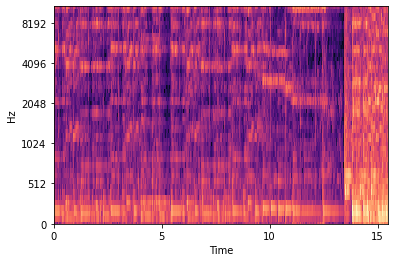

In [15]:
lb.display.specshow(mb_spec[:50,0:1550,0], sr=44100, hop_length=441,
                    x_axis = 'time' , y_axis = 'mel')

### **Training a model using train.py**

In [5]:
%%time
from train import *
main('C-CNN_trial17')

...Concatenating all music-aligned dataframes
...Replacing NaNs with - for output
---dataframe.describe() without blank_chars---
           tk     BD    SD    HH    RD    CC    C2   LT   MT   HT  CH   C3  SC
count   49917  11829  7625  5388  1718  3279  2334  994  391  298  97  302  26
unique      9      3     8     9     5     4     4    5    4    4   3    3   2
top         +      o     o     x     x     X     X    o    o    o   X    X   X
freq    12461  11356  6527  2905  1090  2016  1891  888  315  249  81  264  20

---Unique values and frequencies by column name---
        +      e      a     1     2     3     4   t   s
tk  12461  12459  12446  3206  3202  3199  2867  47  30

        -      o    O   d
BD  38088  11356  430  43

        -     o    g    O    f   d   r   x  0
SD  42292  6527  528  271  136  75  73  14  1

        -     x     X    o   O   s   g  S  d  w
HH  44529  2905  2186  195  35  32  26  5  2  2

        -     x    X    b   g   f
RD  48199  1090  476  113  25  14


/usr/local/lib/python3.6/dist-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


---dataframe.describe() without blank_chars---
           tk     BD    SD    HH    at    ac
count   12474  11829  7024  2907  1540  9801
unique      2      1     1     1     1     1
top         c      o     o     x     o     x
freq     9268  11829  7024  2907  1540  9801

---Unique values and frequencies by column name---
        -     c     C
tk  37443  9268  3206

        -      o
BD  38088  11829

        -     o
SD  42893  7024

        -     x
HH  47010  2907

        -     o
at  48377  1540

        -     x
ac  40116  9801

one_hot_encode: col_list before encoding = ['tk', 'BD', 'SD', 'HH', 'at', 'ac']
one_hot_encode: col_list after encoding = ['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o', 'HH_x', 'at_o', 'ac_x']
train.py main(): FullSet_encoded created!
train.py main():  [0.04385966 0.01127452 0.041625   0.02470234 0.01022058 0.00541067
 0.03450191]
train.py main(): drum_tabber model created!
Model: "functional_1"
_______________________________________

### Loading back in a saved model, configs_dict, and sample song

In [13]:
# load a model back in 
model_to_load_name = 'C-CNN_trial6'
loaded_model, loaded_configs = load_drum_tabber_model(model_to_load_name, SAVED_MODELS_PATH)
print(loaded_configs)

{'class_names_dict': {'0': 'tk_beat', '1': 'tk_downbeat', '2': 'BD_o', '3': 'SD_o', '4': 'HH_x', '5': 'at_o', '6': 'ac_x'}, 'num_classes': 7, 'num_features': 50, 'num_channels': 1, 'n_mels': 50, 'model_type': 'Context-CNN', 'window_size': 4096, 'fmax': 10000, 'hop_size': 441, 'shift_to_db': True, 'n_context_pre': 25, 'n_context_post': 25, 'include_fo_differential': False, 'positive_window_fraction': 0.1, 'negative_window_fraction': 0.1, 'tolerance_window': 25, 'classification_dict': {'clean_date': True, 'keep_dynamics': False, 'keep_bells': False, 'keep_toms_seperate': False, 'hihat_classes': 1, 'cymbal_classes': 1}, 'month_date': '-Nov-27'}


In [14]:
# load sample song and make spectrogram
song_to_test = 'four_years'
#samp_song, sr_song = lb.core.load(os.path.join(SONGS_PATH,song_to_test,song_to_test+'.mp3'), sr=None, mono=True)
exper_song_to_test_path = '/content/gdrive/My Drive/Drum-Tabber-Support-Data/Songs-that-dont-work-yet/let_it_enfold_you/let_it_enfold_you.mp3'
samp_song, sr_song = lb.core.load(exper_song_to_test_path, sr=None, mono=True)
print(f'Number of samples in song is {samp_song.shape[0]}')
spectro = lb.feature.melspectrogram(np.asfortranarray(samp_song), sr = sr_song, n_fft=loaded_configs['window_size'], hop_length = loaded_configs['hop_size'], center = False, n_mels = loaded_configs['n_mels'], fmax= loaded_configs['fmax'])
if loaded_configs['shift_to_db']:
    spectro = lb.power_to_db(spectro, ref = np.max)
spectro_norm = (spectro - spectro.mean())/spectro.std()
if loaded_configs['include_fo_differential']:
    spectro_ftd = lb.feature.delta(data = spectro, width = 9, order=1, axis = -1) 
        # spectro_f(irst)t(ime)d(erivative).shape = (n_mels, t) SAME AS spectro
        # manual normalize of current spectro_ftd
    spectro_ftd_norm = (spectro_ftd - spectro_ftd.mean())/spectro_ftd.std()
    spectro_norm = np.concatenate([spectro_norm, spectro_ftd_norm], axis = 0)
        # spectro.shape = (2* n_mels, t)
spectrogram = spectro_norm.copy()
n_features, n_windows = spectrogram.shape
print(f'spectrogram shape is {spectrogram.shape}')
if loaded_configs['model_type'] == 'Context-CNN':

    pre_context, post_context = loaded_configs['n_context_pre'], loaded_configs['n_context_post']
    input_width = pre_context + 1 + post_context
    min_value = np.min(spectrogram)

    # assign into this np.array filled with the min values of the spectrogram (silence)
    input_array = np.full(shape = (n_windows, n_features, input_width), fill_value = min_value)

    for idx in range(n_windows):
        if idx - pre_context < 0:    # in a window where you would slice before the beginning
            start = pre_context-idx
            input_array[idx, :, start:] = spectrogram[:, 0:idx+post_context+1]
        elif idx + post_context+1 > n_windows: # in a window where you would slice past the end
            end = post_context+1 - (n_windows - idx)
            input_array[idx, :, :input_width-end] = spectrogram[:, idx-pre_context: n_windows ]
        else:    # in a "normal" middle window where you slice into the spectrogram normally
            input_array[idx, :,:] = spectrogram[:, idx-pre_context : idx+post_context+1]

/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Number of samples in song is 13394304
spectrogram shape is (50, 30364)


In [17]:
# making predictions on the sample song
start_ind = 4400
end_ind = start_ind + 4000
predictions = loaded_model(np.expand_dims(input_array,axis=-1)[start_ind:end_ind,:,:,:], training=False)
print(predictions.shape)

(4000, 7)


prediction peaks = [  4  30  40  52  63  85 109 122 130 144 154 165 173 209 219 241 265 285
 300 309 341 348 365 377 388 421 444 458 483 509 521 528 566 575 599 611
 623 642 648 665 707 723 745 756 784 824 840 884 906 913 936 955 981]
prediction peaks = [265 309 443 622 665 745 757 843 936]
prediction peaks = [  4  52  63 119 144 165 220 241 265 280 309 321 366 409 444 566 599 624
 648 706 712 745 824 891 924]


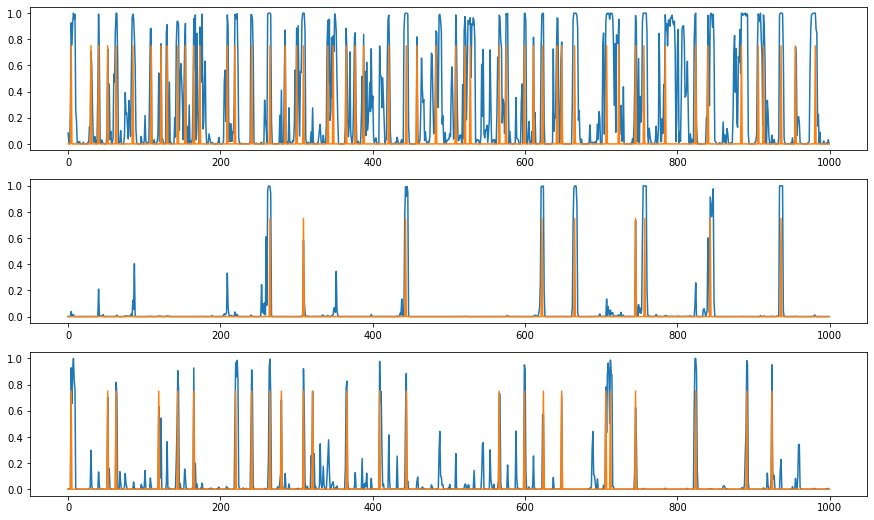

In [18]:
diff_samples = 1000 # every "sample" here is 10 ms. 100 = 1 sec, 1000 = 10 sec
start = 0
end = start + diff_samples

classes_to_show = [6,3,2]   # { 0:tk_beat, 1:tk_downbeat, 2:BD_o, 3:SD_o, 4:HH_x, 5:at_o, 6:ac_x}
num_to_show = len(classes_to_show)

# making a plot to output
plt.rcParams["figure.figsize"]=15,3*num_to_show
fig, axs = plt.subplots(num_to_show)

for idx, val in enumerate(classes_to_show):

    pred = predictions[start:end,val].numpy()
    pred_peaks = np.zeros(shape = pred.shape)
    pred_peaks_idx = lb.util.peak_pick(x = pred, pre_max = 2, post_max = 2, pre_avg = 20, post_avg = 20, 
                                delta = 0.5, wait = 5)

    print(f'prediction peaks = {pred_peaks_idx}')
    if len(pred_peaks_idx) != 0:
        pred_peaks[pred_peaks_idx] = 0.75

    axs[idx].plot(pred)
    axs[idx].plot(pred_peaks)




#ax.vlines(pred_peaks_idx, ymin=0, ymax=1, colors='r', alpha=0.8)


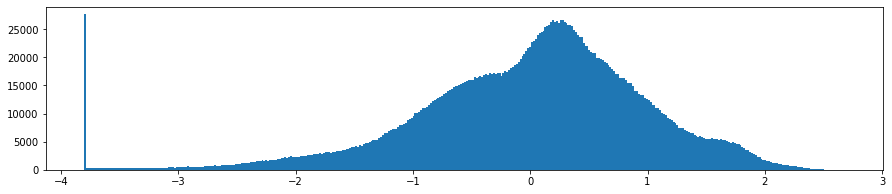

In [20]:
_ = plt.hist(spectrogram.flatten(), bins='auto')
plt.show()

In [ ]:
plt.hist(lb.feature.delta(data = normed_fy, width=9, order=1, axis=-1).flatten(), bins='auto')

In [ ]:
fy_ftd = lb.feature.delta(data = fy, width=9, order = 1, axis=-1)
_ = plt.hist(fy_ftd.flatten(), bins='auto')
plt.show()

In [ ]:
class_names = [x for x in list(encode_df.columns) if '_' in x]
error_metrics_names = ['P', 'N', 'TP', 'FP', 'TN', 'FN']
error_df = pd.DataFrame(0, index=class_names, columns=error_metrics_names)

In [ ]:
print(error_df)

             P  N  TP  FP  TN  FN
tk_beat      0  0   0   0   0   0
tk_downbeat  0  0   0   0   0   0
BD_o         0  0   0   0   0   0
SD_o         0  0   0   0   0   0
HH_x         0  0   0   0   0   0
at_o         0  0   0   0   0   0
ac_x         0  0   0   0   0   0


In [ ]:
error_df.at['tk_downbeat','P'] += 1
print(error_df)

             P  N  TP  FP  TN  FN
tk_beat      0  0   0   0   0   0
tk_downbeat  1  0   0   0   0   0
BD_o         0  0   0   0   0   0
SD_o         0  0   0   0   0   0
HH_x         0  0   0   0   0   0
at_o         0  0   0   0   0   0
ac_x         0  0   0   0   0   0


In [ ]:
sample_starts = np.array([0, 12, 24, 37, 39, 62, 89, 104, 132, 160, 190, 220, 250, 280])
print(len(sample_starts))

14


In [ ]:
frame_starts = np.array([3*idx for idx in range(100)])
peaks = np.array(np.random.rand(100,len(class_names)) > 0.9, dtype=int)
print(peaks)

In [ ]:
for num in sample_starts: 
    bool_mask = ((num-20) <= frame_starts) & (frame_starts <= (num + 20))
    print(bool_mask)

In [ ]:
full_bool_mask = np.stack([((num-5) <= frame_starts) & (frame_starts <= (num + 5)) for num in sample_starts], axis=0)

In [ ]:
full_bool_mask.shape   # num_rows_in_df, n_frames

(14, 100)

In [ ]:
encode_df = encode_df.drop(columns = ['song slice'])

In [ ]:
encode_df.head()

,sample start,tk_beat,tk_downbeat,BD_o,SD_o,HH_x,at_o,ac_x
0,15611,1,1,1,0,0,0,1
1,19056,0,0,0,0,0,0,0
2,22501,0,0,0,0,1,0,0
3,25946,0,0,0,0,0,0,0
4,29391,1,0,0,0,1,0,0


In [ ]:
class_names = [x for x in list(encode_df.columns) if '_' in x]

In [ ]:
labels = encode_df[class_names].to_numpy()
print(labels[0,:])

[1 1 1 0 0 0 1]
